In [1]:
import os
import sys
import numpy as np
from keras.layers import Conv2D, Conv2DTranspose, Input, Dense, Reshape
from keras.layers import LeakyReLU, BatchNormalization, UpSampling2D
from keras.layers import concatenate, GlobalAveragePooling2D
from keras.models import Model
from keras.initializers import RandomNormal, he_normal
from keras.datasets import cifar10
from keras.optimizers import SGD
import keras.backend as K
from tqdm import tqdm, trange

Using TensorFlow backend.


In [2]:
(cifar_images, _), (_, _) = cifar10.load_data()
cifar_images = cifar_images/255

<IPython.core.display.Javascript object>


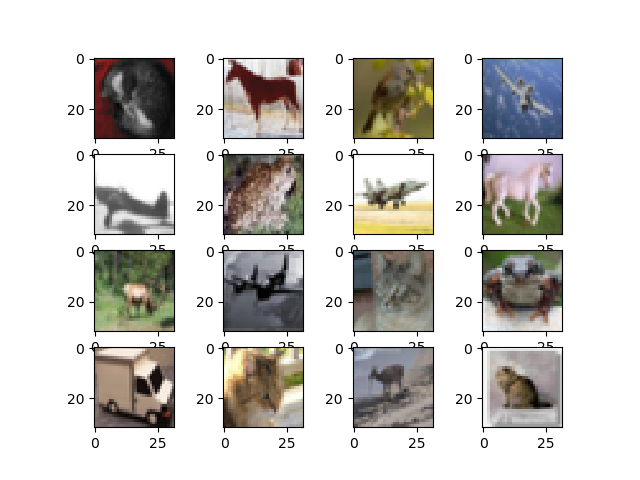

In [3]:
%matplotlib notebook
from matplotlib import pyplot as plt
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(cifar_images[np.random.randint(0,50000)])
plt.show()

Weight initializers

In [4]:
# Random Normal initializer
init1 = RandomNormal(0, 0.01)
init2 = he_normal()

Create GAN generator model

In [5]:
# input layer that accepts our 1D input noise vectors
g_input = Input(shape=(2048,),name='NoiseInput')
# reshape for use in convolutional layers
x = Reshape((4,4,128))(g_input)
# first deconvolutional layer
x = Conv2DTranspose(256,(3,3),padding='same',kernel_initializer=init1)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
# set of 4 convolutional layers
for _ in range(4):
    x = Conv2D(256,(5,5),padding='same',kernel_initializer=init1)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
# Bilinear upsampling
x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
# Set of 5 convolutional layers
for _ in range(5):
    x = Conv2D(256,(5,5),padding='same',kernel_initializer=init1)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
# Bilinear upsampling
x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
# Set of 5 convolutional layers
for _ in range(5):
    x = Conv2D(256,(5,5),padding='same',kernel_initializer=init1)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
# Bilinear upsampling
x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
# Set of 5 convolutional layers
for _ in range(5):
    x = Conv2D(256,(5,5),padding='same',kernel_initializer=init1)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
# final convolutional layer
x = Conv2D(3,(5,5),padding='same',kernel_initializer=init1,activation='sigmoid')(x)

# Put model together
GenModel = Model(g_input,x)

Display model summary to demonstrate correct network architecture

In [6]:
GenModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NoiseInput (InputLayer)      (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         1638656   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
__________

Create GAN discriminator model using an InceptionV3 format

In [28]:
# base number of filters to use
filtnum = 32
# Discriminator input
d_input = Input(shape=(32,32,3),name='input')
# inception block 1
rr = 1
x1 = Conv2D(filtnum*(2**(rr-1)), (1, 1),padding='same',kernel_initializer=init2)(d_input)
x3 = Conv2D(filtnum*(2**(rr-1)), (3, 3),padding='same',kernel_initializer=init2)(d_input)
x51 = Conv2D(filtnum*(2**(rr-1)), (3, 3),padding='same',kernel_initializer=init2)(d_input)
x52 = Conv2D(filtnum*(2**(rr-1)), (3, 3),padding='same',kernel_initializer=init2)(x51)
x = concatenate([x1,x3,x52])
x = Conv2D(filtnum*(2**(rr-1)),(1,1),padding='valid',kernel_initializer=init2)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(filtnum*(2**(rr-1)),(4,4),padding='valid',strides=(2,2),kernel_initializer=init2)(x)
x = LeakyReLU(alpha=0.2)(x)


# repeated inception blocks
for rr in range(2,4):
    x1 = Conv2D(filtnum*(2**(rr-1)), (1, 1),padding='same',kernel_initializer=init2)(x)
    x3 = Conv2D(filtnum*(2**(rr-1)), (3, 3),padding='same',kernel_initializer=init2)(x)
    x51 = Conv2D(filtnum*(2**(rr-1)), (3, 3),padding='same',kernel_initializer=init2)(x)
    x52 = Conv2D(filtnum*(2**(rr-1)), (3, 3),padding='same',kernel_initializer=init2)(x51)
    x = concatenate([x1,x3,x52])
    x = Conv2D(filtnum*(2**(rr-1)),(1,1),padding='valid',kernel_initializer=init2)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filtnum*(2**(rr-1)),(4,4),padding='valid',strides=(2,2),kernel_initializer=init2)(x)
    x = LeakyReLU(alpha=0.2)(x)   

# Use global average pooling to produce a single output
# which is the discriminator score
x = GlobalAveragePooling2D()(x)
# Put model together
DisModel = Model(d_input,x)

Display discriminator model summary

In [8]:
DisModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 32)   896         input[0][0]                      
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 32)   128         input[0][0]                      
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 32)   896         input[0][0]                      
__________________________________________________________________________________________________
conv2d_24 

Create training functions

In [29]:
lrD = 1e-4  # discriminator learning rate
lrG = 1e-4  # generator learning rate

#%% Setup training graph
noise_input = GenModel.inputs[0]
fake_output = GenModel.outputs[0]
real_output = DisModel.inputs[0]

# noise-to-image generator function
fn_genIm = K.function([noise_input],[fake_output])
# discriminator scores
realImScore = DisModel([real_output])
fakeImScore = DisModel([fake_output])
# create mixed output for gradient penalty
ep_input = K.placeholder(shape=(None,1,1,1))
mixed_output = Input(shape=(32,32,3),
                    tensor=ep_input * real_output + (1-ep_input) * fake_output)
mixed_score = DisModel([mixed_output])
# discriminator losses
realDloss = K.mean(realImScore)
fakeDloss = K.mean(fakeImScore)
# gradient penalty loss
grad_mixed = K.gradients([mixed_score],[mixed_output])[0]
norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
grad_penalty = K.mean(K.square(norm_grad_mixed-1))
# composite Discriminator loss
loss_D = fakeDloss - realDloss + 10 * grad_penalty

#%% Image generator loss 
loss_G = -fakeDloss

#%% Training functions
# Discriminator training function
D_trups = SGD(lr=lrD,momentum=0.9,nesterov=True).get_updates(DisModel.trainable_weights,[],loss_D)
fn_trainD = K.function([noise_input, real_output, ep_input],[loss_D], D_trups)

# Generator Training function
G_trups = SGD(lr=lrG,momentum=0.9,nesterov=True).get_updates(GenModel.trainable_weights,[],loss_G)

fn_trainG = K.function([noise_input], [loss_G], G_trups)


In [12]:
# set number of iterations to do
numIter = 100
# set batch size
b_s = 8
# preallocate for the training and validation losses
dis_loss = np.zeros((numIter,1))
gen_loss = np.zeros((numIter,2))

In [ ]:
plt.ion()
fig, ax = plt.subplots()
ax.imshow(samp_im,cmap='gray',vmin=0,vmax=1)
    ax.set_axis_off()
    ax.set_clip_box([0,1])
    ax.set_title('Current training state')
    plt.pause(.001)
    plt.draw()

In [13]:
if 't' in locals():
    del t
t = trange(numIter,file=sys.stdout)
for ii in t:
    for _ in range(3):
        # Train Discriminator
        # grab random training samples
        batch_inds = np.random.choice(cifar_images.shape[0], b_s, replace=False)
        im_batch = cifar_images[batch_inds,...]
        # make some random noise
        noise_batch = np.random.uniform(0,1,size=(b_s,2048))
        # train discrimators
        ϵ1 = np.random.uniform(size=(b_s, 1, 1 ,1))
        errD  = fn_trainD([noise_batch, im_batch, ϵ1])
    dis_loss[ii] = errD
    
    # Train Generator
    errG = fn_trainG([noise_batch])
    gen_loss[ii] = errG        
    t.set_postfix(Dloss=dis_loss[ii,0],GLoss = gen_loss[ii,1])
    
t.close()
del t

100%|██████████| 100/100 [00:38<00:00,  4.22it/s, Dloss=nan, GLoss=nan]  


In [30]:
batch_inds = np.random.choice(cifar_images.shape[0], b_s, replace=False)
im_batch = cifar_images[batch_inds,...]
noise_batch = np.random.uniform(0,1,size=(b_s,2048))
ϵ1 = np.random.uniform(size=(b_s, 1, 1 ,1))
errD  = fn_trainD([noise_batch, im_batch, ϵ1])
print(errD)

In [32]:
errG = fn_trainG([noise_batch])
print(errG)

In [37]:
test_output = fn_genIm([noise_batch])[0]

<IPython.core.display.Javascript object>


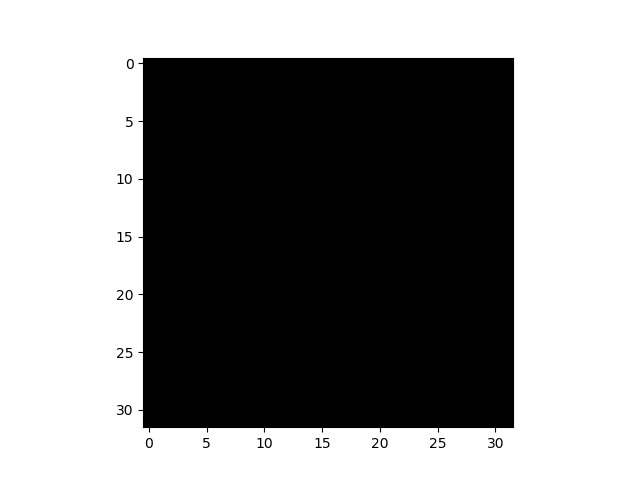

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [40]:
plt.figure()
plt.imshow(test_output[0])
plt.show()